In [ ]:
#!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [ ]:
#!pip3 install opencv-python

In [ ]:
#!pip3 install numpy

[1] batch 10
[1] batch 20
[1] batch 30
[1] batch 40
[1] batch 50
[1] batch 60
[1] batch 70
[1] batch 80
[1] batch 90
[1] batch 100
[1] Training loss: 1502827244.000000
[2] batch 10
[2] batch 20
[2] batch 30
[2] batch 40
[2] batch 50
[2] batch 60
[2] batch 70
[2] batch 80
[2] batch 90
[2] batch 100
[2] Training loss: 939072046.500000
[3] batch 10
[3] batch 20
[3] batch 30
[3] batch 40
[3] batch 50
[3] batch 60
[3] batch 70
[3] batch 80
[3] batch 90
[3] batch 100
[3] Training loss: 686081386.000000
[4] batch 10
[4] batch 20
[4] batch 30
[4] batch 40
[4] batch 50
[4] batch 60
[4] batch 70
[4] batch 80
[4] batch 90
[4] batch 100
[4] Training loss: 537989696.000000
[5] batch 10
[5] batch 20
[5] batch 30
[5] batch 40
[5] batch 50
[5] batch 60
[5] batch 70
[5] batch 80
[5] batch 90
[5] batch 100
[5] Training loss: 451656858.500000
[6] batch 10
[6] batch 20
[6] batch 30
[6] batch 40
[6] batch 50
[6] batch 60
[6] batch 70
[6] batch 80
[6] batch 90
[6] batch 100
[6] Training loss: 404246495.0000

KeyboardInterrupt: ignored

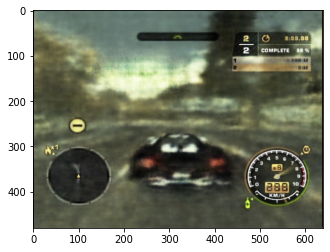

In [ ]:
from functools import partial
from typing import Iterator
import random
import numpy as np
import cv2
import torch.nn as nn
import torch
from torch.utils.data import Dataset, DataLoader, IterableDataset
import torchvision
import sqlite3
import matplotlib.pyplot as plt

BATCH_SIZE = 64#256
#LATENT_SIZE = 512
LATENT_SIZE = 16
DEVICE=torch.device('cuda')
#DEVICE=torch.device('cpu')


BatchNorm2d = partial(nn.BatchNorm2d, eps=0.001, momentum=0.01)
#BatchNorm2d = partial(nn.BatchNorm2d)

class SqueezeExcite(nn.Module):
    def __init__(
        self,
        channels,
        channelsize
    ):
        super(SqueezeExcite, self).__init__()
        self.block = nn.Sequential(
            nn.AvgPool2d(channelsize),
            nn.Flatten(),
            nn.Linear(channels, channels//4),
            nn.LeakyReLU(0.3, False),
            nn.Linear(channels//4, channels),
            nn.Sigmoid(),
            nn.Unflatten(1, (channels, 1, 1))
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x * self.block(x)


class Block(nn.Module):
    def __init__(
        self,
        input_channels: int,
        expanded_channels: int,
        channel_size,
        output_channels: int,
        kernel_size: int = 3,
        padding: int = 1,
        activation1: nn.Module = partial(nn.LeakyReLU, negative_slope=0.3, inplace=False),
        activation2: nn.Module = partial(nn.LeakyReLU, negative_slope=0.3, inplace=False),
        se: bool = True
    ):
        super(Block, self).__init__()
        expander = nn.Conv2d(in_channels=input_channels, out_channels=expanded_channels, kernel_size=1)
        depthwise = nn.Conv2d(in_channels=expanded_channels, out_channels=expanded_channels, kernel_size=kernel_size, stride=2, padding=padding, groups=expanded_channels)
        unexpander = nn.Conv2d(in_channels=expanded_channels, out_channels=output_channels, kernel_size=1)

        self.block = nn.Sequential(
            expander,
            BatchNorm2d(num_features=expanded_channels),
            #nn.LeakyReLU(0.3, True),
            activation1(),
            depthwise,
            BatchNorm2d(num_features=expanded_channels),
            #nn.LeakyReLU(0.3, True),
            activation2(),
            SqueezeExcite(expanded_channels, channel_size//2) if se else nn.Identity(),
            unexpander,
            BatchNorm2d(num_features=output_channels),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.block(x)


class BlockRes(nn.Module):
    def __init__(
        self,
        input_channels: int,
        expanded_channels: int,
        channel_size,
        output_channels: int,
        kernel_size: int = 3,
        padding: int = 1,
        activation1: nn.Module = partial(nn.LeakyReLU, negative_slope=0.3, inplace=False),
        activation2: nn.Module = partial(nn.LeakyReLU, negative_slope=0.3, inplace=False),
        se: bool = True
    ):
        super(BlockRes, self).__init__()
        expander = nn.Conv2d(in_channels=input_channels, out_channels=expanded_channels, kernel_size=1)
        depthwise = nn.Conv2d(in_channels=expanded_channels, out_channels=expanded_channels, kernel_size=kernel_size, stride=1, padding=padding, groups=expanded_channels)
        unexpander = nn.Conv2d(in_channels=expanded_channels, out_channels=output_channels, kernel_size=1)

        self.block = nn.Sequential(
            expander,
            BatchNorm2d(num_features=expanded_channels),
            #nn.LeakyReLU(0.3, True),
            activation1(),
            depthwise,
            BatchNorm2d(num_features=expanded_channels),
            #nn.LeakyReLU(0.3, True),
            activation2(),
            SqueezeExcite(expanded_channels, channel_size) if se else nn.Identity(),
            unexpander,
            BatchNorm2d(num_features=output_channels),
        )
        self.shortcut = nn.Identity() if input_channels == output_channels else nn.Conv2d(input_channels, output_channels, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.shortcut(x) + self.block(x)



class Swish(nn.Module):
  def __init__(self, size):
    super(Swish, self).__init__()
    self.β = nn.parameter.Parameter(
        torch.zeros((1, *size), device=DEVICE, dtype=torch.float),
        requires_grad=True
    )

  def forward(self, x: torch.Tensor):
    return x * (x * self.β).sigmoid()


class VAE(nn.Module):
    def __init__(self):
        super().__init__()

        self.checkpoint_segments = 16

        s_96 = partial(Swish, size=(96, 1, 1))
        s_240 = partial(Swish, size=(240, 1, 1))
        s_120 = partial(Swish, size=(120, 1, 1))
        s_144 = partial(Swish, size=(144, 1, 1))
        s_288 = partial(Swish, size=(288, 1, 1))
        s_576 = partial(Swish, size=(576, 1, 1))

        # Encoder inspired by mobilenetv3-small
        self.encoder = nn.Sequential(
            # 3 * 480 * 640
            # Downscale the image to 224x224 using bilinear algorithm
            nn.Upsample(size=(224, 224), mode='bilinear', align_corners=True), # 3*224*224
            nn.Conv2d(3, 16, 3, 2, 1), # 16*112*112
            ##
            Block(16, 16, 112, 16), # 16*56*56
            Block(16, 72, 56, 24, se=False), # 24*28*28
            BlockRes(24, 88, 28, 24, se=False), # 24*28*28
            Block(24, 96, 28, 40, 5, 2, s_96, s_96), # 40*14*14
            BlockRes(40, 240, 14, 40, 5, 2, s_240, s_240), # 40*14*14
            BlockRes(40, 240, 14, 40, 5, 2, s_240, s_240), # 40*14*14
            BlockRes(40, 120, 14, 48, 5, 2, s_120, s_120), # 48*14*14
            BlockRes(48, 144, 14, 48, 5, 2, s_144, s_144), # 48*14*14
            Block(48, 288, 14, 96, 5, 2, s_288, s_288), # 96*7*7
            BlockRes(96, 576, 7, 96, 5, 2, s_576, s_576), # 96*7*7
            BlockRes(96, 576, 7, 96, 5, 2, s_576, s_576), # 96*7*7
            nn.Conv2d(96, 576, 1), # 576*7*7
            Swish(size=(576, 1, 1)),
            #nn.Conv2d(576, LATENT_SIZE*2, 7), # (LATENT_SIZE * 2)*1*1
            nn.Conv2d(576, LATENT_SIZE*2, 1), # (LATENT_SIZE * 2)*7*7
            nn.Conv2d(LATENT_SIZE*2, LATENT_SIZE*2, 7, groups=LATENT_SIZE*2), # (LATENT_SIZE * 2)*1*1
            nn.Flatten(1), # (LATENT_SIZE * 2)
        )
        #self.encoder = torch.utils.checkpoint.checkpoint_sequential(self.encoder, chunks)

        # 640 = 2 * 2 * 2 * 2 * 2 * 4 * 5
        # 480 = 2 * 2 * 2 * 2 * 2 * 3 * 5

        decoder_multiplier = 4

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (LATENT_SIZE, 1, 1)),
            nn.ConvTranspose2d(LATENT_SIZE, decoder_multiplier*256, 5, 1, 0, bias=False), # 1024 * 5 * 5
            BatchNorm2d(num_features=decoder_multiplier*256),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*256, decoder_multiplier*128, (3, 4), (3, 4), 0, bias=False), # 512 * 15 * 20
            BatchNorm2d(num_features=decoder_multiplier*128),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*128, decoder_multiplier*64, 4, 2, 1, bias=False), # 256 * 30 * 40
            BatchNorm2d(num_features=decoder_multiplier*64),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*64, decoder_multiplier*32, 4, 2, 1, bias=False), # 128 * 60 * 80
            BatchNorm2d(num_features=decoder_multiplier*32),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*32, decoder_multiplier*16, 4, 2, 1, bias=False), # 64 * 120 * 160
            BatchNorm2d(num_features=decoder_multiplier*16),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*16, decoder_multiplier*8, 4, 2, 1, bias=False), # 32 * 240 * 320
            BatchNorm2d(num_features=decoder_multiplier*8),
            nn.LeakyReLU(0.3, False),
            nn.ConvTranspose2d(decoder_multiplier*8, 3, 4, 2, 1, bias=False), # 3 * 480 * 640
            nn.Tanh()
        )

    def reparameterise(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            #eps = std.data.new(std.size()).normal_()
            eps = torch.autograd.Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
      #print(f'x size: {x.size()}')
      #encoded = torch.utils.checkpoint.checkpoint(self.encoder, x, preserve_rng_state=False)#, use_reentrant=False)
      encoded = self.encoder(x)
      #print(f'Encoded size: {encoded.size()}')
      mu_logvar = encoded.view(-1, 2, LATENT_SIZE)
      mu = mu_logvar[:, 0, :]
      logvar = mu_logvar[:, 1, :]
      return mu, logvar

    def decode(self, z):
      #return torch.utils.checkpoint.checkpoint(self.decoder, z, preserve_rng_state=False)#, use_reentrant=False)
      return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterise(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar

    def sample(self, n_samples):
      z = torch.randn((n_samples, LATENT_SIZE)).to(DEVICE)
      return self.decode(z)


class FrameIter(IterableDataset):
    def __init__(self, db: sqlite3.Connection):
        super(FrameIter).__init__()
        self.db = db
        self.transformations = nn.Sequential(
            torchvision.transforms.Resize(
                size=(480, 640)
            )
        )
        self.normalize = torchvision.transforms.Normalize(
                (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
        )

    def get_iterator(self) -> Iterator[torch.Tensor]:
        def getiterator():
            while True:
                for (imgbuf,) in self.db.execute('SELECT image FROM whole_frames2 ORDER BY RANDOM();'):
                    yield imgbuf

        return iter(self.parse_image(imgbuf) for imgbuf in getiterator())

    def parse_image(self, buf):
        buf = np.asarray(bytearray(buf), dtype='uint8')
        img = self.normalize(
            self.transformations(
                torch.from_numpy(
                    np.transpose(
                        cv2.imdecode(buf, cv2.IMREAD_COLOR)[:, :, ::-1],
                        (2, 0, 1)
                    ).copy()
                )
            ).float().__div__(255.0)
        )
        return img

    def __iter__(self) -> Iterator[torch.Tensor]:
        return self.get_iterator()


# # Reconstruction + KL divergence losses summed over all elements and batch
# def loss_function(x_hat, x, mu, logvar):

#     # reconstruction loss (pushing the points apart)
#     BCE = nn.functional.binary_cross_entropy(
#         x_hat, x.mul(0.5).add(0.5), reduction='sum'
#     )

#     # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
#     # (enforce a radius of 1 in each direction + pushing the means towards zero)
#     KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))

#     return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(x_hat, x, mu, logvar):

    # reconstruction loss (pushing the points apart)
    #print('x_hat', x_hat)
    #print('x', x)
    BCE = nn.functional.mse_loss(
        x_hat, x, reduction='sum'
    )

    # KL divergence loss (the relative entropy between two distributions a multivariate gaussian and a normal)
    # (enforce a radius of 1 in each direction + pushing the means towards zero)
    KLD = 0.5 * torch.sum(logvar.exp() - logvar - 1 + mu.pow(2))
    #KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

    return BCE + KLD # we can use a beta parameter here (BCE + beta * KLD)



def show_img(pytorch_img: torch.Tensor, fig_num: int, example: bool = False):
    img = np.transpose(
        pytorch_img.detach().cpu().mul(0.5).add(0.5).mul(255.0).numpy(),
        (1, 2, 0)
    )[:,:,:].astype(np.uint8)
    plt.imshow(img)
    # plt.show(block=False)
    # plt.draw()
    # plt.pause(0.001)
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/mostwantedVAE4/{"example" if example else ""}{fig_num}.png')
    #print(img)
    #cv2.imshow('Frame', img)
    #cv2.waitKey(delay=1)

with sqlite3.connect('file:/content/drive/MyDrive/Colab Notebooks/frames.sqlite3?mode=ro', uri=True) as db:
    framedataset = FrameIter(db)
    framedataloader = DataLoader(
        framedataset,
        batch_size=BATCH_SIZE,
        num_workers=0
    )
    framedataloader = iter(framedataloader)
    model = VAE().to(device=DEVICE)
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.0001#,
        #eps=1e-6,
        #amsgrad=True
        #weight_decay=0.01
    )

    # savestate = torch.load('/content/drive/MyDrive/Colab Notebooks/mostwantedVAE3/checkpoint4.pt')
    # model.load_state_dict(savestate['state'])
    # optimizer.load_state_dict(savestate['optimizer'])
    # del savestate
    for epoch in range(1, 101):
        x = next(framedataloader).to(device=DEVICE)
        model.train(False)
        show_img(x[0], example=True, fig_num=epoch)
        show_img(model(x[0][None,:, :, :])[0][0], fig_num=epoch)

        model = model.train()
        train_loss = 0
        for batch in range(1, 101):# if epoch != 1 else 1001):
            #print(f"Epoch {epoch}\tbatch {batch}")
            #if epoch != 1 or batch == 1:
            x = next(framedataloader).to(device=DEVICE)
            #t: torch.Tensor = x
            #x.requires_grad_()
            x_hat, mu, logvar = model(x)
            loss = loss_function(x_hat, x, mu, logvar)
            #print(loss.item())
            train_loss += loss.item()
            loss.backward()
            #optimizer.zero_grad()
            optimizer.step()
            optimizer.zero_grad()
            if batch % 10 == 0:
                # optimizer.step()
                # optimizer.zero_grad()
                print(f'[{epoch}] batch {batch}')
        print(f"[{epoch}] Training loss: {train_loss:4f}")
        torch.save({"state": model.state_dict(), "optimizer": optimizer.state_dict()}, f"/content/drive/MyDrive/Colab Notebooks/mostwantedVAE4/checkpoint{epoch}.pt")